## BigQuery Magic - Query results to Pandas Dataframe
The following code uses Jupyter **magic** to load the results of a BigQuery query into a Pandas dataframe.

Note that we do not need to import any libraries!

In [1]:
%%bigquery stations_df --verbose
SELECT
  name, id,
  state,
  ST_GeogPoint(longitude, latitude) AS g
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
LIMIT
  1000

Executing query with job ID: 8f3bf23b-811a-4e59-9c8c-a851da3a5953
Query executing: 1.16s
Query complete after 1.48s


In [2]:
stations_df.head()

,name,id,state,g
0,BOWEN CHEETHAM SALT,ASN00033094,,POINT(148.2247 -20.0133)
1,DUMBLETON ROCKS ALERT,ASN00033300,,POINT(149.0753 -21.1439)
2,ONE MILE BRIDGE ALERT,ASN00040836,,POINT(152.7461 -27.6272)
3,CURUCA,BR000047003,,POINT(-47.85 -0.73)
4,PRIMAVERA,BR000047004,,POINT(-47.1 -0.93)


## Location search via GIS
Now search for stations near Washinton DC.  You can set the lat long of another station in **ST_GeogPoint**

In [3]:
%%bigquery dc_stations_df --verbose
WITH params AS (
  SELECT ST_GeogPoint(-77.0032, 38.9) AS center,
         50 AS maxn_stations,
         50 AS maxdist_km
),
distance_from_center AS (
  SELECT
    id,
    name,
    state,
    ST_GeogPoint(longitude, latitude) AS loc,
    ST_Distance(ST_GeogPoint(longitude, latitude), params.center) AS dist_meters
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_stations`,
    params
  WHERE ST_DWithin(ST_GeogPoint(longitude, latitude), params.center, params.maxdist_km*1000)
)
SELECT * from distance_from_center

Executing query with job ID: c6d220a4-5dc1-464f-912a-7b595807e2a8
Query executing: 0.66s
Query complete after 1.03s


In [4]:
dc_stations_df.head()

,id,name,state,loc,dist_meters
0,US1DCDC0009,WASHINGTON 2.0 SSW,DC,POINT(-77.0224 38.8766),3087.351459
1,US1DCDC0007,WASHINGTON 1.2 SE,DC,POINT(-76.9982 38.8943),767.429691
2,US1DCDC0002,WASHINGTON 3.7 NNW,DC,POINT(-77.0337 38.9574),6906.390130
3,US1DCDC0019,THE WHITE HOUSE,DC,POINT(-77.037 38.8958),2962.079439
4,US1DCDC0010,WASHINGTON 5.0 N,DC,POINT(-77.0245 38.9773),8790.585440


## Use parameters in BigQuery search
Set the **lat** and **long** as python variables.

Note that we need to cast the **FLOAT64** as **String**, since Jupyter **BigQuery Magic** mis-interprets the negative sign as a variable.

In [5]:
long = -77.0032
lat  = 38.9
params = {"longitude": f'{long}', "latitude" : f'{lat}'}

Send the **JSON String** to the query via the **params** flag and then **CAST** them to **FLOAT64**.

In [6]:
%%bigquery dc_stations_2_df --params $params --verbose
WITH params AS (
  SELECT ST_GeogPoint(CAST(@longitude as FLOAT64), CAST(@latitude as FLOAT64)) AS center,
         50 AS maxn_stations,
         50 AS maxdist_km
),
distance_from_center AS (
  SELECT
    id,
    name,
    state,
    longitude, 
    latitude,
    ST_Distance(ST_GeogPoint(longitude, latitude), params.center) AS dist_meters
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_stations`,
    params
  WHERE ST_DWithin(ST_GeogPoint(longitude, latitude), params.center, params.maxdist_km*1000)
)
SELECT * from distance_from_center

Executing query with job ID: 350d7b79-4989-4d6e-aa26-0601d848088b
Query executing: 0.48s
Query complete after 0.80s


In [7]:
dc_stations_2_df.head()

,id,name,state,longitude,latitude,dist_meters
0,US1DCDC0009,WASHINGTON 2.0 SSW,DC,-77.0224,38.8766,3087.351459
1,US1DCDC0007,WASHINGTON 1.2 SE,DC,-76.9982,38.8943,767.429691
2,US1DCDC0002,WASHINGTON 3.7 NNW,DC,-77.0337,38.9574,6906.390130
3,US1DCDC0019,THE WHITE HOUSE,DC,-77.0370,38.8958,2962.079439
4,US1DCDC0010,WASHINGTON 5.0 N,DC,-77.0245,38.9773,8790.585440


## Plot the stations on a Map
Install and import **geopandas**

In [8]:
!pip install geopandas

In [9]:
import geopandas as gpd

Create a GeoDataFrame from the **pandas** DataFrame.

In [10]:
dc_geo_df = gpd.GeoDataFrame(dc_stations_2_df, geometry = gpd.points_from_xy(dc_stations_2_df.longitude, dc_stations_2_df.latitude))

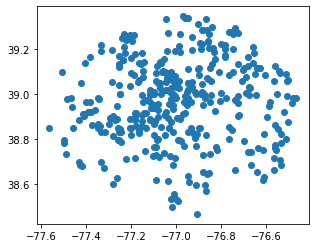

In [11]:
dc_geo_df.plot()

In [12]:
!pip install descartes

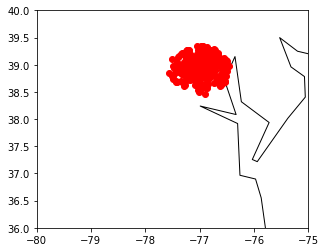

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
ax.set_xlim([-80, -75])
ax.set_ylim([36,40])
dc_geo_df.plot(ax=ax, color = 'red')

In [36]:
%%bigquery airwx --verbose
SELECT
  wx.date,
  wx.prcp,
  f.departure_delay,
  f.arrival_airport
FROM (
  SELECT
    CAST(date as STRING) AS date,
    value/10 AS prcp
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_2005`
  WHERE
    id = 'USW00094846'
    AND qflag IS NULL
    AND element = 'PRCP') AS wx
JOIN
  `bigquery-samples.airline_ontime_data.flights` AS f
ON
  f.date = wx.date
WHERE
  f.departure_airport = 'ORD'

Executing query with job ID: 1161cdde-2e51-4cd5-8cac-48727ebcfd82
Query executing: 3.61s
Query complete after 3.98s


In [37]:
airwx.head()

,date,prcp,departure_delay,arrival_airport
0,2005-09-29,0.0,88.0,IAH
1,2005-09-19,12.7,31.0,IAH
2,2005-09-28,15.0,29.0,IAH
3,2005-09-22,18.0,60.0,IAH
4,2005-08-05,0.0,32.0,IAH


In [41]:
!pip install seaborn
import seaborn as sns

Text(0, 0.5, 'Flight delays (minutes)')

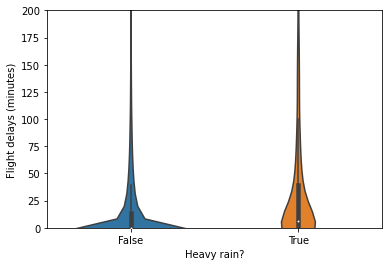

In [44]:
rainyday = airwx.prcp > 25.4 # 1 inch of rain
ax = sns.violinplot(x=rainyday, y=airwx.departure_delay)
ax.set_ylim(0, 200)
ax.set_xlabel('Heavy rain?')
ax.set_ylabel('Flight delays (minutes)')